## Convolution Neural Networks : Application
- We will :
    - Create a mood classifier using the TF keras Sequential API
    - Build a ConvNet to identify sign language digits using the TF keras Functional API.
- We will be able to :
    - Build and train a ConvNet in TensorFlow for a binary classification problem.
    - Build and train a ConvNet in TensorFlow for a multclass classification problem.
    - Explain different use cases for the Sequential and Functional APIs.

# 1. Packages

In [6]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops

np.random.seed(1)

## 1.1 Load the Data and Split the Data into Train/Test Sets
- We'll be using the Happy House Dataset, which contains images of people's faces. Our task will be to build a ConvNet that determines whether the people in the image are similing or not because they only get to enter the house if they're similing.

In [7]:
def load_happy_dataset():
    train_dataset = h5py.File('train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [8]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_happy_dataset()

# Normalize image vector
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


- We can display the images contained in the dataset. Images are 64x64 pixels in RGB format (3 channels).

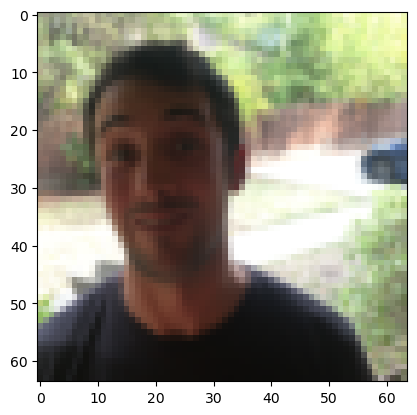

In [9]:
index = 123
plt.imshow(X_train_orig[index])
plt.show()

# 2. Layers in TF Keras
- In TF keras, we don't have to write code directly to create layers. Rather TF keras has pre-defined layers we can use.
- When we create a layer in TF keras, we are creating a function that takes some input and transforms it into an output we can reuse later.

# 3. The Sequential API
- Most practial applications of deep learning today are built using programming frameworks, which have many built-in functions we can simply call. Keras is a high-level abstraction built on top of TensorFlow, which allows for even more simplified and optimize model creation and training.
- We'll create a model using TF keras Sequential API, which allows us to build layer by layer, and is ideal for building models where each layer has exactly one input tensor and one output tensor.
- Using the Sequential API is simple and straightforward, but is only appropriate for simpler, more straightforward tasks.

## 3.1 Create the Sequential Model
- The TensorFlow Keras Sequential API can be used to build simple models with layer operations that proceed in a Sequential order.
- We can also add layers incremetally to a Sequential model with the .add() method or remove them using the .pop() methoud, much like we would in a regular Python list.
- Actually, we can think of a sequential model as behaving like a list of layers like python lists, Sequantial layers are ordered, and the order in which they are specified matters. If our model is non-linear or contains layers with multiple inputs or outputs, a Sequential model wouldn't be the right choice.
- For any layer construction in Keras, we'll need to specify the input shape in advance. This is because in Keras, the shape of the weights is based on the shape of the inputs. The weights are only created when the model first sees some input data. Sequential models can be created by passing a list of layers to the Sequential constuctor.

### HappyModel 
- Implement the happyModel function to build the following model : 
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU ->MAXPOOL ->FLATTEN -> DENSE. 
- Also, plug in the following parametes for all the steps :
    - ZeroPadding2D : Padding 3, input shape 64x64x3
    - Conv2D : Use 32 7x7x filters, stide 1
    - BatchNormalization : For axis 3
    - ReLU
    - MaxPool2D : Using default parameters
    - Flatten the previous output
    - Fully connected (Dense) layer : Apply a fully connected layer with 1 neuron and a sigmoid activation.

In [10]:
def happyModel():
    '''
    Implements the forward propagation for the binary classification mdoel :
        ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE
        
    Arguments :
    None
    
    Returns :
    model : TF keras model (object containing the information for the entire training process)
    '''
    
    model = tf.keras.Sequential([
        ## ZeroPadding2D with padding 3, input shape of 64 x 64 x 3
        tfl.ZeroPadding2D( padding=(3, 3), input_shape=(64, 64, 3)),
        
        ## Conv2D with 32 7x7 filters and stride of 1
        tfl.Conv2D(32, (7, 7), strides=(1, 1)),
        
        ## BatchNormalization for axis 3
        tfl.BatchNormalization(axis=3),
        
        ## ReLU
        tfl.ReLU(),
        
        ## Max Pooling 2D with default parameters
        tfl.MaxPool2D(),
        
        ## Flatten layer
        tfl.Flatten(),
        
        ## Dense layer with 1 unit for output & 'sigmoid' activation
        tfl.Dense(1, activation='sigmoid')
        
        ])
    
    return model 

- Now that our model is created, we can compile it for training with an optimizer and loss of our choice. When the string accuracy is specified as a metric, the type of accuracy used will be automatically converted based on the loss function used. This is one of the many optimizations built into TensorFlow that make our life easier!

In [11]:
happy_model = happyModel()
happy_model.compile(optimizer='adam',
                   loss = 'binary_crossentropy',
                   metrics=['accuracy'])

- It's time to check our model's parameters with .summary() method. This will display the types of layers we have, the shape of the outputs, and how many parameters are in each layer.

In [12]:
happy_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)         0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        4736      
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                        

## 3.2 Train and Evaluate the Model
- After creating the model, compiling it with our chocie of optimizer and loss function, and doing a sanity check on its contents, we are now ready to build.
- Simply call .fit() to train

In [13]:
happy_model.fit(X_train, Y_train, epochs=10, batch_size=16)

Epoch 1/10


38/38 [==============================] - 2s 23ms/step - loss: 1.3247 - accuracy: 0.6983
Epoch 2/10
38/38 [==============================] - 1s 24ms/step - loss: 0.2063 - accuracy: 0.9167
Epoch 3/10
38/38 [==============================] - 1s 24ms/step - loss: 0.1420 - accuracy: 0.9450
Epoch 4/10
38/38 [==============================] - 1s 23ms/step - loss: 0.1490 - accuracy: 0.9400
Epoch 5/10
38/38 [==============================] - 1s 23ms/step - loss: 0.1120 - accuracy: 0.9533
Epoch 6/10
38/38 [==============================] - 1s 22ms/step - loss: 0.0999 - accuracy: 0.9700
Epoch 7/10
38/38 [==============================] - 1s 24ms/step - loss: 0.1549 - accuracy: 0.9500
Epoch 8/10
38/38 [==============================] - 1s 23ms/step - loss: 0.0688 - accuracy: 0.9817
Epoch 9/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0636 - accuracy: 0.9817
Epoch 10/10
38/38 [==============================] - 1s 22ms/step - loss: 0.0983 - accuracy: 0.9633


- Use .evaluate() to evaluate aganist our test set. This function will print the value of the loss function and the performance metrics specified during the compilation of the model. In this case, the binary_crossentropy and the accuracy respectively

In [14]:
happy_model.evaluate(X_test, Y_test)

5/5 [==============================] - 0s 15ms/step - loss: 0.0938 - accuracy: 0.9667


[0.09381092339754105, 0.9666666388511658]

But what if we need to build a model with shared layers, branches, or multiple inputs and outputs? This is where Sequential, with its beautifully simple yer limited functionality, won't be able to help us.

# 4. The Functional API
- We'll use Keras' flexible Functional API to build a ConvNet that can differentiate b/w 6 sign language digits.
- The Functional API can handle models with non-linear topology, shared layers, as well as layers with multiple inputs or outputs. Imagine that, where the Sequential API requires the model to move in a linear fashion through its layers, the Function API allows much more flexibility. Where Sequential is a straigh line, a Functional model is a graph, where the nodes of layers can connect in many more ways than one.
- In the visual example below, the one possible direction of the movement Sequential model is shown in contrast to a skip connection, which is just one of the many ways a Functional model can be constructed. A skip connection, as we might have guessed, skips some layer in the network and feeds the output to a later layer in the network.
    - 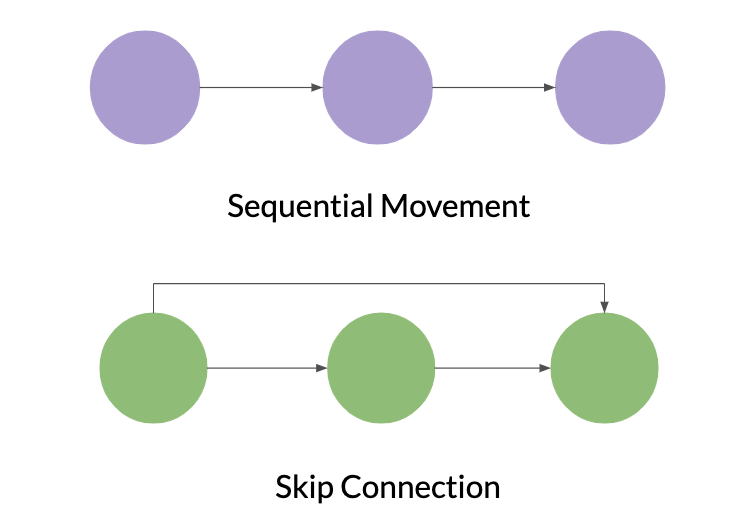

## 4.1 Load the SIGNS Dataset
- The SIGNS dataset is a collection of 6 signs represnting numbers from 0 to 5.

In [15]:
def load_signs_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [16]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

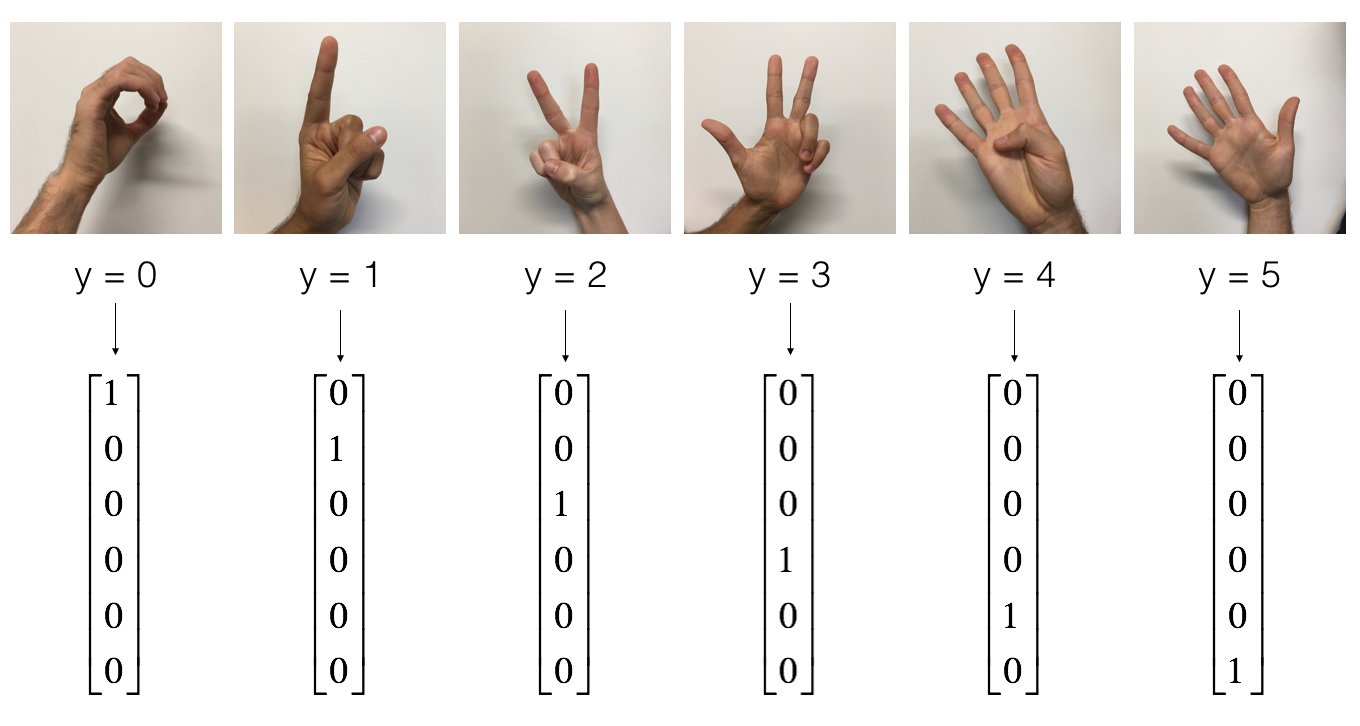

y = 4


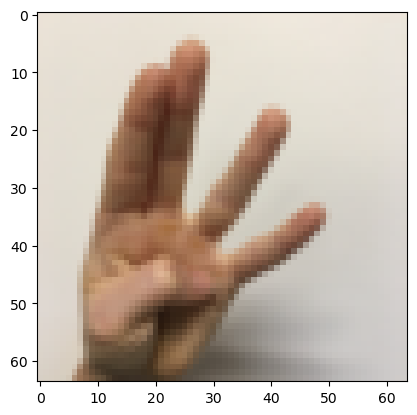

In [17]:
# Example of an image from the dataset
index = 9
plt.imshow(X_train_orig[index])
print("y = "+str(np.squeeze(Y_train_orig[:, index])))

## 4.2 Split the Data into Train/Test Sets
- Since this is an image dataset, it is more natural to apply a ConvNet to it.

In [18]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [19]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


## 4.3 Forward Propagation
- In TensorFlow, there are built-in functions that impelements the convolution steps for us. By now, we should be familiar with how TensorFlow builds computational graphs. In the Functional API, we create a graph of layers. This is what allows such great flexibility.
- However, the following model could also be defined using the Sequential API since the information flow is on a single line.
- Begin building our graph of layers by creating an input node that functions as a callable object.
    - input_img = tf.keras.Input(shape=input_shape)
- Then, create a new node in the graph of layers by calling a layer on the input_img object :
    - tf.keras.layers.Conv2D(filters=.., kernal_size=..,padding='same')(input_img) 
    - tf.keras.layers.MaxPool2D(pool_size=(f,f), strides=(s,s), padding='same) : MaxPool2D() downsamples our input using a window size (f, d) and strides of size (s, s) to carry out max pooling over each window. For max pooling, we usually operate on a single example at a time and a single channel at a time. 
    - tf.keras.layers.ReLU() : Computes the elementwise ReLU of Z (which can be any shape).
    - tf.keras.layers.flatten() : Given a tensor 'P', this function takes each training (or test) example in the batch and flattens it into a 1D vector.
        - if a tensor P has the shape (batch_size, h, w, c) it returns a flattened tensor with shape (batch size, k) where k = h x w x c. 'k' equals the product of all the dimension sizes other than the first dimension.
    - tf.keras.layers.Dense(units=.., activation='softmax')(F) : Given the flattened input F, it returns the output computed using a fully connected layer. The fully connected layer automatically initialized weights in the graph and keeps on training them as we train the model. Hence, we did not need to initialize those weights when initializing the parameters.
- Before creating the model, we'll need to define the output using the last of the function's compositions
    - outputs = tf.keras.layers.Dense(units = 6, activation='softmax')(F)
    
- 'kernel' and 'filter' are used to refer to the same thing. The word 'filter' accounts for the amount of 'kernels' that will be used in a single convolution layer. 'Pool' is the name of the operation that takes the max or average value of the kernels. This is why the parameters pool_size refers to kernel_size, and we use (f, f) to refer to the filter size.

### Convolutional_model
- Implement the convolutional_model function below to build the followinf model :
     - CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FALTTEN ->  DENSE
- Plug in the following parameters for all the steps : 
    - Conv2D : Use 8 4 by 4 filters, stride 1, padding is 'SAME'
    - ReLU
    - MaxPool2D : Use an 8 by 8 filter size and an 8 b 8 stride, padding is 'SAME'
    - Conv2D : Use 16 2 by 2 filters, stride 1, padding is 'SAME'
    - ReLU
    - MaxPool2D : Use a 4 by 4 filter size and a 4 by 4 stride, padding is 'SAME'
    - Flatten the previous output.
    - Fully-connected (Dense) layer : Apply a fully connected layer with 6 neurons and a softmax activation.

In [20]:
# GRADED FUNCTION: convolutional_model

def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity and grading purposes, you'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    input_img -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    input_img = tf.keras.Input(shape=input_shape)
    ## CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    Z1 = tf.keras.layers.Conv2D(8, 4, strides =(1, 1), padding='SAME')(input_img)
    # RELU
    A1 = tf.keras.layers.ReLU()(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.keras.layers.MaxPool2D(pool_size = (8, 8), strides=(8, 8), padding = 'SAME')(A1)
    # CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = tf.keras.layers.Conv2D(16, 2, strides =(1, 1), padding='SAME')(P1)
    # RELU
    A2 = tf.keras.layers.ReLU()(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.keras.layers.MaxPool2D(pool_size = (4, 4), strides=(4, 4), padding = 'SAME')(A2)
    # FLATTEN
    F = tf.keras.layers.Flatten()(P2)
    # Dense layer
    # 6 neurons in output layer. Hint: one of the arguments should be "activation='softmax'" 
    outputs = tf.keras.layers.Dense(6, activation='softmax')(F)

    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [23]:
conv_model = convolutional_model((64, 64, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 8)         392       
                                                                 
 re_lu_5 (ReLU)              (None, 64, 64, 8)         0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 8, 8, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 16)          528       
                                                                 
 re_lu_6 (ReLU)              (None, 8, 8, 16)          0         
                                                           

- Bothe the Sequential and Functional APIs return a TF keras model object. The only difference is how inputs are handled inside the object model.

# 4.4 Train the model

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
17/17 [==============================] - 1s 22ms/step - loss: 1.8227 - accuracy: 0.1657 - val_loss: 1.7961 - val_accuracy: 0.2000
Epoch 2/100
17/17 [==============================] - 0s 14ms/step - loss: 1.7909 - accuracy: 0.2333 - val_loss: 1.7864 - val_accuracy: 0.2167
Epoch 3/100
17/17 [==============================] - 0s 15ms/step - loss: 1.7852 - accuracy: 0.2185 - val_loss: 1.7796 - val_accuracy: 0.2417
Epoch 4/100
17/17 [==============================] - 0s 14ms/step - loss: 1.7771 - accuracy: 0.2444 - val_loss: 1.7713 - val_accuracy: 0.2750
Epoch 5/100
17/17 [==============================] - 0s 13ms/step - loss: 1.7666 - accuracy: 0.3269 - val_loss: 1.7583 - val_accuracy: 0.3583
Epoch 6/100
17/17 [==============================] - 0s 13ms/step - loss: 1.7542 - accuracy: 0.3509 - val_loss: 1.7433 - val_accuracy: 0.3833
Epoch 7/100
17/17 [==============================] - 0s 16ms/step - loss: 1.7386 - accuracy: 0.3852 - val_loss: 1.7278 - val_accuracy: 0.4250
Epoch 

17/17 [==============================] - 0s 14ms/step - loss: 0.5701 - accuracy: 0.8185 - val_loss: 0.6315 - val_accuracy: 0.8000
Epoch 59/100
17/17 [==============================] - 0s 13ms/step - loss: 0.5603 - accuracy: 0.8241 - val_loss: 0.6220 - val_accuracy: 0.8000
Epoch 60/100
17/17 [==============================] - 0s 13ms/step - loss: 0.5505 - accuracy: 0.8278 - val_loss: 0.6123 - val_accuracy: 0.8083
Epoch 61/100
17/17 [==============================] - 0s 13ms/step - loss: 0.5410 - accuracy: 0.8343 - val_loss: 0.6044 - val_accuracy: 0.8167
Epoch 62/100
17/17 [==============================] - 0s 13ms/step - loss: 0.5320 - accuracy: 0.8343 - val_loss: 0.5970 - val_accuracy: 0.8250
Epoch 63/100
17/17 [==============================] - 0s 15ms/step - loss: 0.5236 - accuracy: 0.8389 - val_loss: 0.5883 - val_accuracy: 0.8250
Epoch 64/100
17/17 [==============================] - 0s 13ms/step - loss: 0.5150 - accuracy: 0.8389 - val_loss: 0.5808 - val_accuracy: 0.8250
Epoch 65/100

# History Object
- The history object is an output of the .fit() operation, and provides a record of all the loss and metric values in memory. It's stored as a dictionary that we can retrieve at history.history

In [25]:
history.history

{'loss': [1.822718620300293,
  1.7909390926361084,
  1.7852293252944946,
  1.7770898342132568,
  1.766626238822937,
  1.7541531324386597,
  1.7386218309402466,
  1.7216053009033203,
  1.7004753351211548,
  1.6745364665985107,
  1.6418334245681763,
  1.6042227745056152,
  1.5612117052078247,
  1.5155649185180664,
  1.4684199094772339,
  1.4203847646713257,
  1.3740878105163574,
  1.3291711807250977,
  1.2863636016845703,
  1.2455878257751465,
  1.2084465026855469,
  1.1730985641479492,
  1.1399110555648804,
  1.108098030090332,
  1.0787124633789062,
  1.0522340536117554,
  1.0259068012237549,
  0.9998485445976257,
  0.9773451089859009,
  0.9541828036308289,
  0.9332048892974854,
  0.912979006767273,
  0.8932659029960632,
  0.874895453453064,
  0.8567482233047485,
  0.8403945565223694,
  0.8235830664634705,
  0.8078795671463013,
  0.7931357622146606,
  0.7785627245903015,
  0.765705406665802,
  0.7511947154998779,
  0.7371283769607544,
  0.7239592671394348,
  0.7115325331687927,
  0.6997

C:\Users\surya\AppData\Local\Temp\ipykernel_3688\973814028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
C:\Users\surya\AppData\Local\Temp\ipykernel_3688\973814028.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

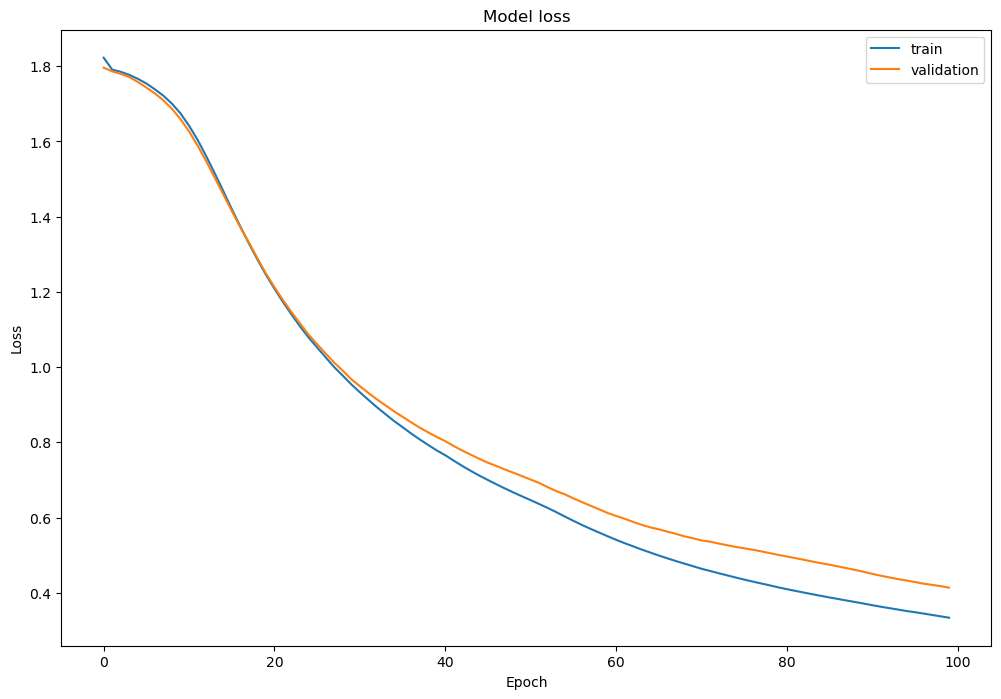

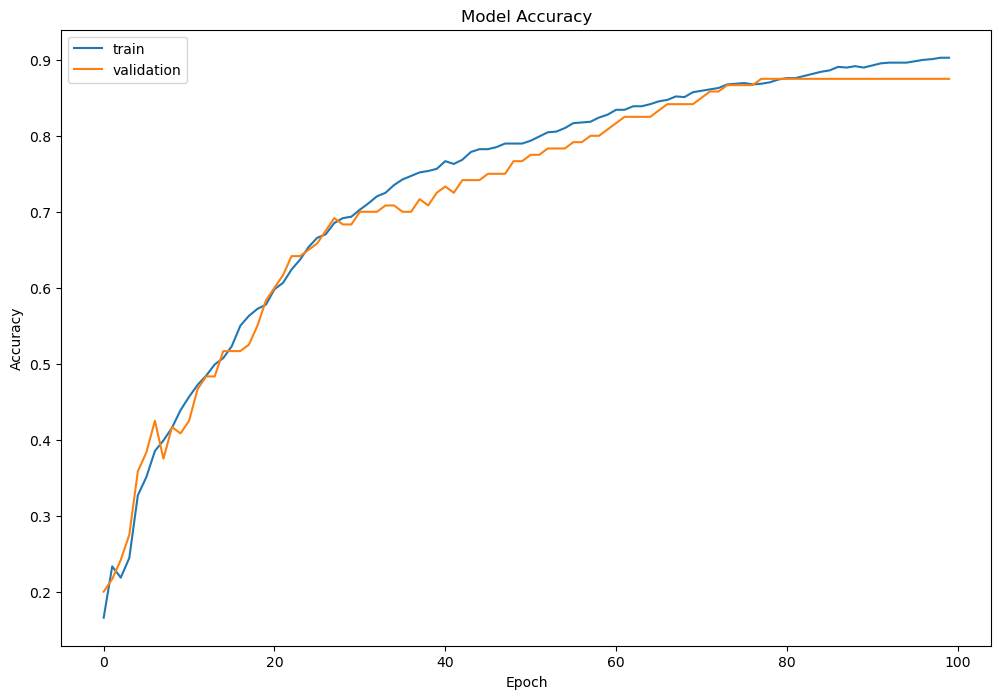

In [26]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')